In [1]:
import dynamo as dyn
import numpy as np
import time
import autograd 


# Demo of the ODE model  
- This code is based on the original Matlab code from Ruoshi Yuan and Ying Tang. 
- Tang, Ying, Ruoshi Yuan, Gaowei Wang, Xiaomei Zhu, and Ping Ao. 2017. “Potential Landscape of High Dimensional Nonlinear Stochastic Dynamics with Large Noise.” Scientific Reports 7 (1): 15762.

The ordinary differential equation (ODE) for this demo is: 
$
\left\{
\begin{array}{lll}
\dot{x}_1 &=& -1 + 9 x_1 - 2 x_1^3 + 9 x_2 - 2 x_2^3, \\
\dot{x}_2 &=& 1 - 11 x_1 - 2 x_1^3 + 11 x_2 - 2 x_2^3, \\
\end{array}
\right . 
$

For the sake of simplicity, we provide an identity diffusion matrix $D = [1, 0; 0, 1]$. Therefore, 
the corresponding SDE can be modelled as: 
$
\left\{
\begin{array}{lll}
\dot{x}_1 &=& -1 + 9 x_1 - 2 x_1^3 + 9 x_2 - 2 x_2^3 + \zeta{x_1}(t), \\
\dot{x}_2 &=& 1 - 11 x_1 - 2 x_1^3 + 11 x_2 - 2 x_2^3 + \zeta{x_2}(t), \\
\end{array}
\right .
$
where $\eta(t)$ denotes the Gaussian white noise with $<\zeta(t)\zeta^{\tau}(t^{'}) = 2 \epsilon \sigma (t - t^{'})>$


In [2]:
def ODE(x):
    dx1 = -1 + 9 * x[0] - 2 * pow(x[0], 3) + 9 * x[1] - 2 * pow(x[1], 3)
    dx2 = 1 - 11*x[0] + 2 * pow(x[0], 3) + 11 * x[1] - 2 * pow(x[1], 3)

    ret = np.array([[dx1], [dx2]]).reshape(x.shape)

    return ret

def autoODE(x):
    dx1 = -1 + 9 * x[0] - 2 * pow(x[0], 3) + 9 * x[1] - 2 * pow(x[1], 3)
    dx2 = 1 - 11*x[0] + 2 * pow(x[0], 3) + 11 * x[1] - 2 * pow(x[1], 3)

    ret = autonp.array([[dx1], [dx2]]).reshape(x.shape)

    return ret

1. identify fixed points 
2. calculate the potential of fixed points after setting fixed point 1 as the reference 
3. plot the least action path 
4. map the entire potential landscape 

In [3]:
stable, saddle = dyn.tl.gen_fixed_points(func=dyn.tl.ODE, auto_func = dyn.tl.autoODE, dim_range=[-10, 10], RandNum=5000, EqNum = 2, x_ini = None)
print(stable)
print(saddle)


[[-2.38765722 -2.17792037  2.05944469  2.30042576]
 [ 2.34705142 -2.11798259  2.12495022 -2.34325851]]
[[-0.12336289  0.32906971  2.1724076  -2.2736269   0.10121962]
 [-2.22987412  2.21942924  0.21935159 -0.22978941  0.01012217]]


In [4]:
points = np.hstack((stable, saddle))
points.shape[1]

9

In [5]:
point_end = np.array([[0.10121962], [0.01012217]])
point_end

array([[0.10121962],
       [0.01012217]])

# Calculate potential with the least action path method 
To calculate the potential of the fixed points, we can either try to utilize the analytical solution of the potential function (but this is often not possible for most of the cases) or use certain numeric algorithms. In the following, we will first show how to calculate potential with the least action path method  (Tang, et. al, 2017) which takes the vector field function as the input. For this approach, we need to specify a reference point, **ref_point** and then apply the least action path algorithm. Note that the least action path tells you how to convert from one cell state to another cell state optimally with the minimal work. 

The identification of least action path is achieved by fixing the starting (point_start) and target cell state (point_end) and search middle points in the entire transcriptomic space that leads to the minimal action, calculated through the vector field function F, when following the path. At this moment, we sample 300 points in the middle and the minimization of action is achieved through the miminize function from scipy. It is not efficient and takes about 1 hour to finish the optimization. We are actively working on using different optimization strategy to accelerate this stage. 

In [6]:
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

# what are your inputs, and what operation do you want to 
# perform on each input. For example...
inputs = range(points.shape[1]) 
inputs = tqdm(inputs)

def action(i):
    pot = dyn.tl.action(n_points=350, tmax=2, point_start=points[:, i][:, None], point_end=point_end, Function = dyn.tl.ODE, boundary=[-4, 4], DiffusionMatrix = dyn.tl.DiffusionMatrix)
    return pot
     
num_cores = points.shape[1] # multiprocessing.cpu_count()
     
time0 = time.time()
results = Parallel(n_jobs=num_cores)(delayed(action)(i) for i in inputs)
time1 = time.time()

print('time is ', time1 - time0)

100%|██████████| 9/9 [00:00<00:00, 67.72it/s]


time is  6684.434830904007


In [7]:
#results
for i in range(points.shape[1]): 
    
    print('potential for the ', i, '-th point', points[:, i], 'is ', results[i][0])
    
time1 = time.time()


potential for the  0 -th point [-2.38765722  2.34705142] is  32.08576858478302
potential for the  1 -th point [-2.17792037 -2.11798259] is  22.270818785430833
potential for the  2 -th point [2.05944469 2.12495022] is  18.174249193202982
potential for the  3 -th point [ 2.30042576 -2.34325851] is  27.400865056031147
potential for the  4 -th point [-0.12336289 -2.22987412] is  12.66765476752188
potential for the  5 -th point [0.32906971 2.21942924] is  12.207610909229128
potential for the  6 -th point [2.1724076  0.21935159] is  10.22179679719242
potential for the  7 -th point [-2.2736269  -0.22978941] is  14.73591182642542
potential for the  8 -th point [0.10121962 0.01012217] is  5.937570665102228e-16


# calculate the analytical potential difference 
Fortunately, for this model system, we know the exact functional form of the potential. We can then calculate the exact potential value given the same reference point and compare with the numeric result. We find that our numeric result is pretty close to the analytical solution which is pretty awesome. This also validate that our numeric algorithm can estimate the true potential value accurately.  

In [8]:
# potential
# potential[0][1][1, :]
# Input the potential function if it is known in prior.
# It can be used to compare with the value calculated by least action
# method.

def exact_potential(points, ref_point): 
    ref_point_ind = np.where([np.allclose(points[:, i][:, None],  ref_point, atol=1e-5) for i in range(points.shape[1])])[0][0]
    
    pot = np.zeros((points.shape[1], 1))
    
    for i in range(points.shape[1]):
        x, y = points[0, i], points[1, i]
        pot[i] = -5 * (x**2 + y**2) + (x**4 + y**4) / 2 + x * y + x
        
    pot = pot - pot[ref_point_ind]
    
    return pot 

exact_potential(points, point_end) 


array([[-32.6671709 ],
       [-22.45056737],
       [-18.2096797 ],
       [-27.97753188],
       [-12.47443013],
       [-12.02396411],
       [-10.10166586],
       [-14.55000595],
       [  0.        ]])

# visualizing the least action path 
With the functional form of a vector field, dynamo enables global mapping of potential landscapes that reflect the relative stability of cell state,  most probable paths between any cell state. The most probable path (least action path) essentially tells how to convert one cell type to any other optimally! Let us visualize each fixed point's least action path to the reference point in the middle. Note that the value on the side of each fixed point corresponds to the potential when using the middle fixed point as the reference point


Text(0.5, 1.0, 'Least action paths')

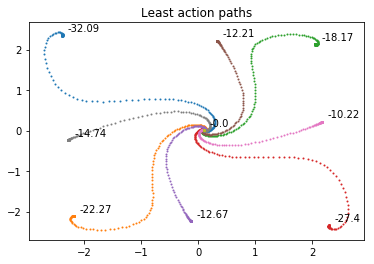

In [9]:
import matplotlib.pyplot as plt
for i in range(len(results)):
    plt.scatter(results[i][1][0, :], results[i][1][1, :], s=1)
    plt.text(results[i][1][0, 0] + 0.1, results[i][1][1, 0] + 0.1, s= np.around(-results[i][0], decimals=2) )
    
plt.title('Least action paths')

# Calculate the least action path for the Hippocampus data 
Here we will use the reconstruct vector field function to calculate the least action path 

In [10]:
import scipy.io
VecFld = scipy.io.loadmat('/home/xqiu/proj/dynamo/data/VecFld.mat')

def vector_field_function(x, VecFld = VecFld):
    '''Learn an analytical function of vector field from sparse single cell samples on the entire space robustly.
    Reference: Regularized vector field learning with sparse approximation for mismatch removal, Ma, Jiayi, etc. al, Pattern Recognition
    '''
    if(len(x.shape) == 1):
        x = x[None, :]
    K= dyn.tl.con_K(x, VecFld['X'], VecFld['beta'])

    K = K.dot(VecFld['C'])

    return K.T

def vector_field_function_auto(x, VecFld = VecFld, autograd = False):
    '''Learn an analytical function of vector field from sparse single cell samples on the entire space robustly.
    Reference: Regularized vector field learning with sparse approximation for mismatch removal, Ma, Jiayi, etc. al, Pattern Recognition
    '''
    if(len(x.shape) == 1):
        x = x[None, :]
    K= auto_con_K(x, VecFld['X'], VecFld['beta'])

    K = K.dot(VecFld['C'])

    return K


In [11]:

stable = np.array([[-18, -15], [-5, -20], [-5, -10], [5, 22], [25, -5]]).T
saddle = np.empty((2, 0))

points = np.hstack((stable, saddle))
ref_point = np.array([[-5], [-10]])


In [12]:
from tqdm import tqdm

tmp = range(points.shape[1]) 
print(tmp)
inputs = tqdm(tmp)

max_dist = np.sqrt((25 + 5)**2 + (-5 + 10)**2)
tmax = max_dist / np.min(VecFld['grid_V'][VecFld['grid_V'] > 0])

def action(i):
    pot = dyn.tl.action(n_points=350, tmax=200, point_start=points[:, i][:, None], point_end=ref_point, Function = vector_field_function, boundary=[-4, 4], DiffusionMatrix = dyn.tl.DiffusionMatrix)
    return pot
     
num_cores = points.shape[1] # multiprocessing.cpu_count()
     
## 2. map potential for fixed points 
time0 = time.time()
velocyto_results_1 = Parallel(n_jobs=num_cores)(delayed(action)(i) for i in inputs)
time1 = time.time()

print(time1 - time0)


range(0, 5)


100%|██████████| 5/5 [00:00<00:00, 114.96it/s]


38154.91035652161


Text(0.5, 1.0, 'Least action paths of the Hippocampus data')

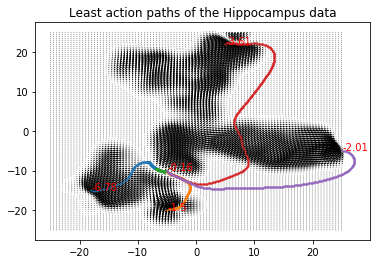

In [13]:
plt.quiver(VecFld['grid'][:, 0], VecFld['grid'][:, 1], VecFld['grid_V'][:, 0], VecFld['grid_V'][:, 1])

for i in range(len(velocyto_results_1)):
    plt.scatter(velocyto_results_1[i][1][0, :], velocyto_results_1[i][1][1, :], s=1)
    plt.text(velocyto_results_1[i][1][0, 0] + 0.1, velocyto_results_1[i][1][1, 0] + 0.1, s= np.around(-velocyto_results_1[i][0], decimals=2), color = 'red')
    
plt.title('Least action paths of the Hippocampus data')